# Advanced Retrieval Techniques

RAG works by providing an LLM with additional context that is retrieved from relevant data so that it can generate a better-informed response.

[Rag Architecture](https://huggingface.co/learn/cookbook/en/advanced_rag)

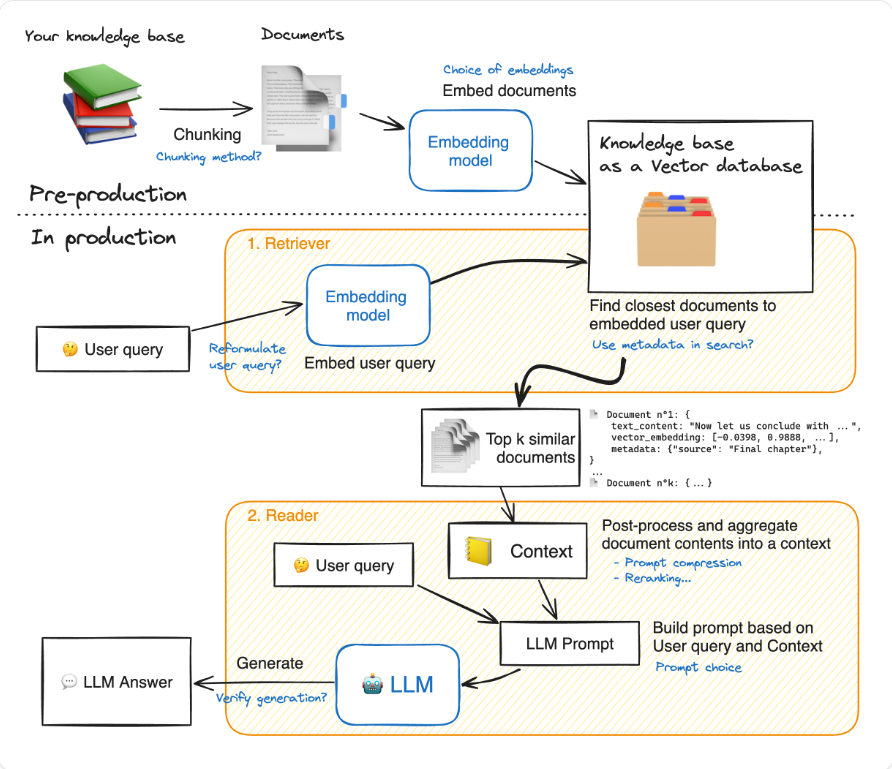

## Dual Encoder

A Dual Encoder is a machine learning architecture designed to map two inputs (e.g., queries and documents) into a shared vector space. Each input is processed independently using its respective encoder, allowing for efficient computation of similarity scores.

#### How Dual Encoders Work
1. **Separate Encoding**:

* A query and a document are independently passed through two separate encoders (often neural networks, e.g., BERT, Sentence Transformers).
* Each encoder transforms the input into a fixed-dimensional embedding vector in the shared embedding space.
2. **Similarity Matching**:

* Once embeddings are generated for queries and documents, their similarity is computed using measures like:
  * Cosine similarity: Measures the angle between vectors.
  * Dot product: Scales based on magnitude.
3. Training:

* During training, positive (query-document pairs) and negative samples are used.
* The model minimizes the distance between embeddings of positive pairs while maximizing the distance between embeddings of negative pairs.


[Research Paper:](https://arxiv.org/pdf/2204.07120)



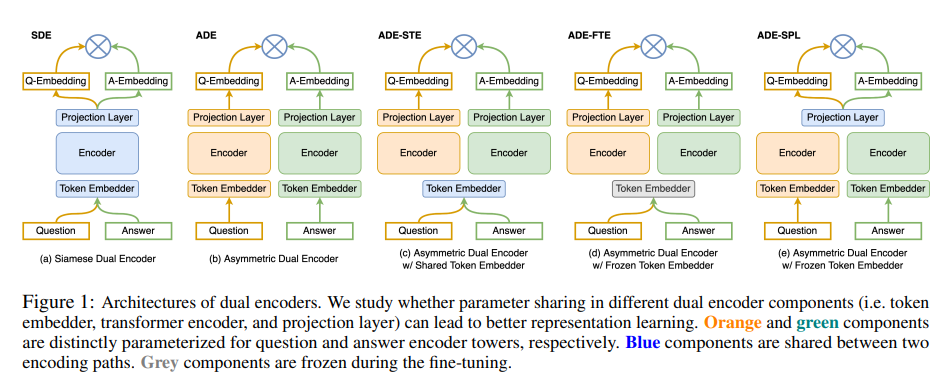

In [2]:
from transformers import DPRQuestionEncoderTokenizer, DPRQuestionEncoder
import torch

# Load DPR tokenizer and model
tokenizer = DPRQuestionEncoderTokenizer.from_pretrained("facebook/dpr-question_encoder-single-nq-base")
model = DPRQuestionEncoder.from_pretrained("facebook/dpr-question_encoder-single-nq-base")

# query
query = "What is Retrieval-Augmented Generation?"

# Tokenize the query
inputs = tokenizer(query, return_tensors="pt")

# Generate embeddings
with torch.no_grad():
    embeddings = model(**inputs).pooler_output

print(embeddings.shape)  # [batch_size, hidden_size]

Some weights of the model checkpoint at facebook/dpr-question_encoder-single-nq-base were not used when initializing DPRQuestionEncoder: ['question_encoder.bert_model.pooler.dense.bias', 'question_encoder.bert_model.pooler.dense.weight']
- This IS expected if you are initializing DPRQuestionEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DPRQuestionEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


torch.Size([1, 768])


## Cross Encoder

This method re-ranks the retrieved documents according to a score that quantifies their relevancy with the input query.

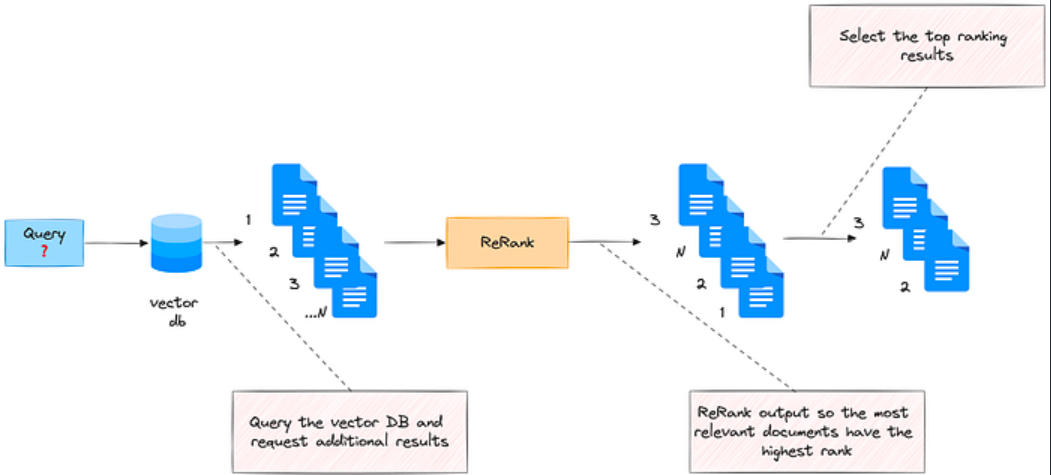

To compute this score, we will use a cross-encoder.

A cross-encoder is a deep neural network that processes two input sequences together as a single input. This allows the model to directly compare and contrast the inputs, understanding their relationship in a more integrated and nuanced way.

Cross-encoders can be used for Information Retrieval: given a query, encode it with all retrieved documents. Then, sort them in a decreasing order. The high-scored documents are the most relevant ones.

[See SBERT.net Retrieve & Re-rank for more details.](https://www.sbert.net/examples/applications/retrieve_rerank/README.html)

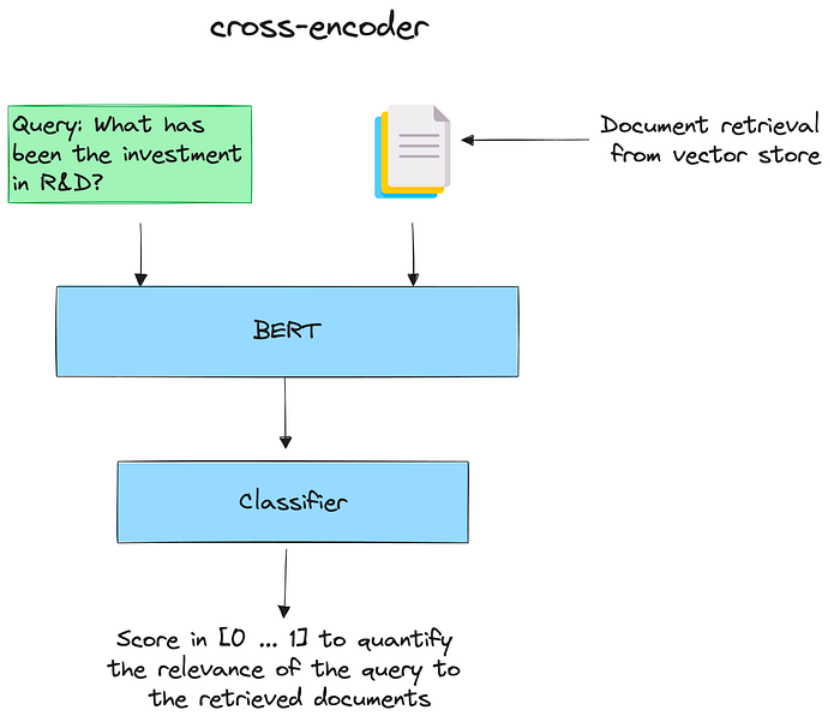

In [ ]:
from sentence_transformers import CrossEncoder

# 1. Load a pre-trained CrossEncoder model
model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

# 2. Predict scores for a pair of sentences
scores = model.predict([
    ("How many people live in Berlin?", "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers."),
    ("How many people live in Berlin?", "Berlin is well known for its museums."),
])
# => array([ 8.607138 , -4.3200774], dtype=float32)

# 3. Rank a list of passages for a query
query = "How many people live in Berlin?"
passages = [
    "Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers.",
    "Berlin is well known for its museums.",
    "In 2014, the city state Berlin had 37,368 live births (+6.6%), a record number since 1991.",
    "The urban area of Berlin comprised about 4.1 million people in 2014, making it the seventh most populous urban area in the European Union.",
    "The city of Paris had a population of 2,165,423 people within its administrative city limits as of January 1, 2019",
    "An estimated 300,000-420,000 Muslims reside in Berlin, making up about 8-11 percent of the population.",
    "Berlin is subdivided into 12 boroughs or districts (Bezirke).",
    "In 2015, the total labour force in Berlin was 1.85 million.",
    "In 2013 around 600,000 Berliners were registered in one of the more than 2,300 sport and fitness clubs.",
    "Berlin has a yearly total of about 135 million day visitors, which puts it in third place among the most-visited city destinations in the European Union.",
]
ranks = model.rank(query, passages)

# Print the scores
print("Query:", query)
for rank in ranks:
    print(f"{rank['score']:.2f}\t{passages[rank['corpus_id']]}")

Query: How many people live in Berlin?
8.92	The urban area of Berlin comprised about 4.1 million people in 2014, making it the seventh most populous urban area in the European Union.
8.61	Berlin had a population of 3,520,031 registered inhabitants in an area of 891.82 square kilometers.
8.24	An estimated 300,000-420,000 Muslims reside in Berlin, making up about 8-11 percent of the population.
7.60	In 2014, the city state Berlin had 37,368 live births (+6.6%), a record number since 1991.
6.35	In 2013 around 600,000 Berliners were registered in one of the more than 2,300 sport and fitness clubs.
5.42	Berlin has a yearly total of about 135 million day visitors, which puts it in third place among the most-visited city destinations in the European Union.
3.45	In 2015, the total labour force in Berlin was 1.85 million.
0.33	Berlin is subdivided into 12 boroughs or districts (Bezirke).
-4.24	The city of Paris had a population of 2,165,423 people within its administrative city limits as of Jan

## Maximal Marginal Relevance (MMR)

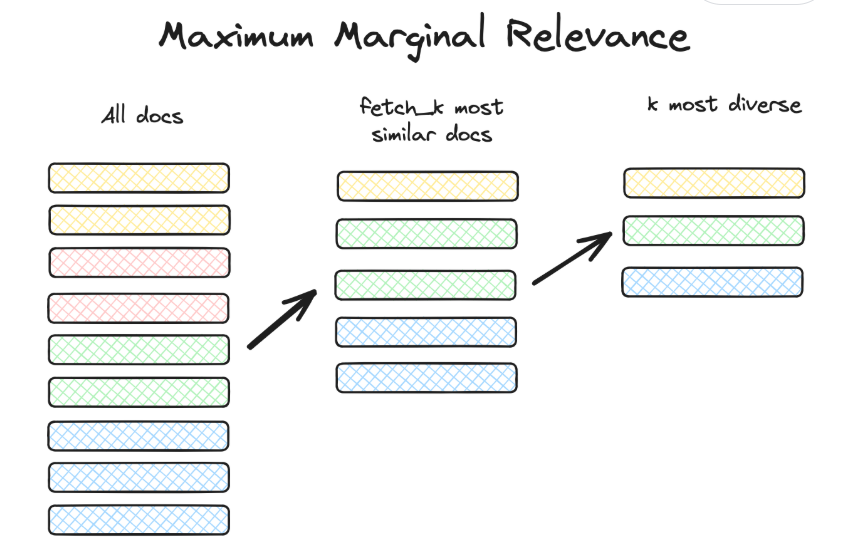

Maximal Marginal Relevance (MMR) is a method used in information retrieval to select documents that are both relevant to the query and diverse with respect to the previously selected documents. This approach helps in reducing redundancy and increasing the coverage of different aspects of the query in the selected documents.

### MMR Formula

The formula for MMR is:

$$
\text{MMR}(D_i) = \arg\max_{D_i \in R \setminus S} \left[ \lambda \cdot \text{Sim}(D_i, Q) - (1 - \lambda) \cdot \max_{D_j \in S} \text{Sim}(D_i, D_j) \right]
$$

### Explanation

- **$\text{MMR}(D_i)$**: Maximal Marginal Relevance score for document $D_i$.
- **$\arg\max$**: Argument of the maximum value.
- **$D_i \in R \setminus S$**: Candidate documents that are in the set $R$ (all documents) but not in the set $S$ (selected documents).
- **$\lambda$ (lambda)**: Trade-off parameter between relevance and diversity (0 ≤ $\lambda$ ≤ 1).
- **$\text{Sim}(D_i, Q)$**: Similarity between document $D_i$ and the query $Q$.
- **$\max_{D_j \in S} \text{Sim}(D_i, D_j)$**: Maximum similarity between document $D_i$ and any document $D_j$ in the selected set $S$.

### Steps

1. **Compute Relevance Score**: $\text{Sim}(D_i, Q)$ for each candidate document $D_i$ with respect to the query $Q$.
2. **Compute Diversity Score**: $\max_{D_j \in S} \text{Sim}(D_i, D_j)$ for each candidate document $D_i$ with respect to the selected documents $S$.
3. **Calculate MMR Score**: $\lambda \cdot \text{Sim}(D_i, Q) - (1 - \lambda) \cdot \max_{D_j \in S} \text{Sim}(D_i, D_j)$.
4. **Select Document**: Choose the document $D_i$ with the highest MMR score and add it to the selected set $S$.

In [ ]:
!pip install chromadb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.3/628.3 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 76.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.6/278.6 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 72.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.2/93.2 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.8/54.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 7.0 MB/s eta 0:00:00

In [ ]:
from langchain_community.vectorstores.chroma import Chroma
from sentence_transformers import SentenceTransformer

# Custom embedding wrapper for Sentence Transformers
class CustomEmbeddings:
    def __init__(self, model_name):
        self.model = SentenceTransformer(model_name)

    def embed_documents(self, texts):
        return self.model.encode(texts, convert_to_numpy=True)

    def embed_query(self, text):
        return self.model.encode(text, convert_to_numpy=True)

# Initialize the custom embedding model
embedding = CustomEmbeddings('all-MiniLM-L6-v2')

# Initialize Chroma VectorStore with SentenceTransformer embeddings
texts = [
    """The Amanita phalloides has a large and imposing epigeous (aboveground) fruiting body (basidiocarp).""",
    """A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.""",
    """A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.""",
]

smalldb = Chroma.from_texts(texts, embedding=embedding)

# Query for Similarity Search
question = "Tell me about all-white mushrooms with large fruiting bodies"
query_embedding = embedding.embed_query(question)

# Perform Similarity Search
results = smalldb.similarity_search_by_vector(query_embedding, k=2)

# Display Results
for i, result in enumerate(results, 1):
    print(f"Result {i}:\n{result.page_content}\n")


Result 1:
A mushroom with a large fruiting body is the Amanita phalloides. Some varieties are all-white.

Result 2:
A. phalloides, a.k.a Death Cap, is one of the most poisonous of all known mushrooms.



## Embedding adaptors

This method leverages user feedback on the relevancy of the retrieved documents to train an adapter.

> An adapter is a lightweight alternative to fully fine-tune a pre-trained model. Currently, adapters are implemented as small feedforward neural networks that are inserted between layers of pre-trained models.


The underlying goal of training an adapter is to alter the embedding query to produce better retrieval results for a specific task.

An embedding adapter is a stage that can be inserted after the embedding phase and before the retrieval. Think about it as a matrix (with trained weights) that takes the original embedding and scales it.



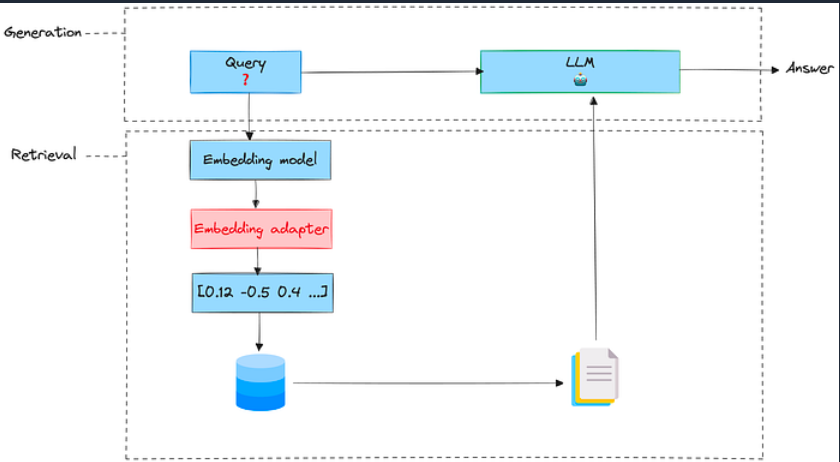

```python
!pip install embedding_adapter

from embedding_adapter import EmbeddingAdapter
adapter = EmbeddingAdapter()
adapter.fit(query_embeddings, document_embeddings, labels)
adapter.transform(new_embeddings)
```
Once you've trained the adapter, you can use patch your pre-trained embedding model.
```python

patch = adapter.patch()
adapted_embeddings = patch(original_embedding_fn("SAMPLE_TEXT"))
```



Resources:
[blog](https://research.trychroma.com/embedding-adapters)

In [ ]:
from embedding_adapter import EmbeddingAdapter

# Initialize the adapter
adapter = EmbeddingAdapter()

# Fit the adapter using query-document pairs
adapter.fit([query_embedding], doc_embeddings, labels)

# Transform the query and document embeddings
adapted_query_embedding = adapter.transform([query_embedding])[0]
adapted_embeddings = adapter.transform(doc_embeddings)

# Perform retrieval with adapted embeddings
def similarity_search_adapted(query_embedding, doc_embeddings, docs, k=3):
    similarities = np.dot(doc_embeddings, query_embedding)
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return [docs[i] for i in top_k_indices]

adapted_results = similarity_search_adapted(adapted_query_embedding, adapted_embeddings, docs)


# Experimentation

### Installing Libraries

In [ ]:
# !pip install -U langchain-community

In [ ]:
# !pip install pypdf

In [ ]:
# !pip install --upgrade openai

### Importing Libraries

In [ ]:
import os
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import Chroma
from sentence_transformers import SentenceTransformer
from transformers import pipeline
from sklearn.decomposition import PCA
import numpy as np
from transformers import AutoTokenizer

### Step 1: Pre-processing

In [ ]:
# Step 1: Load and Parse PDF
# Use PyPDFLoader to load the uploaded PDF
pdf_path = '/content/Benchmark-GLUE-data-pdf.pdf'
loader = PyPDFLoader(pdf_path)
documents = loader.load()

# Split the document into chunks for processing
text_splitter = CharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
docs = text_splitter.split_documents(documents)


### Dual Encoder

In [ ]:
# Dual encoders create separate embeddings for queries and documents.
# They are efficient for similarity-based retrieval by mapping both queries and documents into the same embedding space.

# Use SentenceTransformers for embedding generation
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# Generate embeddings for the documents
doc_texts = [doc.page_content for doc in docs]
doc_embeddings = embedding_model.encode(doc_texts, convert_to_numpy=True)

# Perform Dual Encoder Retrieval
def similarity_search(query_embedding, doc_embeddings, docs, k=3):
    similarities = np.dot(doc_embeddings, query_embedding)
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return [docs[i] for i in top_k_indices]

query = "Explain the purpose of the GLUE benchmark."
query_embedding = embedding_model.encode(query, convert_to_numpy=True)
dual_encoder_results = similarity_search(query_embedding, doc_embeddings, docs)

# Display Dual Encoder Results
def display_dual_encoder_results():
    print("\n=== Dual Encoder Results ===")
    for i, result in enumerate(dual_encoder_results):
        print(f"Rank {i+1}: {result.page_content}\n")

display_dual_encoder_results()


=== Dual Encoder Results ===
Rank 1: Published as a conference paper at ICLR 2019
2005), SST (Socher et al., 2013), CR (Hu & Liu, 2004), and SUBJ (Pang & Lee, 2004). Other
tasks are so close to being solved that evaluation on them is relatively uninformative, such as MPQA
(Wiebe et al., 2005) and TREC question classiﬁcation (V oorhees et al., 1999). In GLUE, we attempt
to construct a benchmark that is both diverse and difﬁcult.
McCann et al. (2018) introduce decaNLP, which also scores NLP systems based on their perfor-
mance on multiple datasets. Their benchmark recasts the ten evaluation tasks as question answer-
ing, converting tasks like summarization and text-to-SQL semantic parsing into question answering
using automatic transformations. That benchmark lacks the leaderboard and error analysis toolkit of
GLUE, but more importantly, we see it as pursuing a more ambitious but less immediately practical
goal: While GLUE rewards methods that yield good performance on a circumscribed s

### Step 3: Cross Encoder

In [ ]:
# Cross encoders compute a relevance score for query-document pairs by encoding them together.
# They are computationally expensive but provide more accurate relevance scoring.

cross_encoder = pipeline("text-classification", model="cross-encoder/ms-marco-MiniLM-L-6-v2")
from transformers import AutoTokenizer

# Initialize the tokenizer for truncation
tokenizer = AutoTokenizer.from_pretrained("cross-encoder/ms-marco-MiniLM-L-6-v2")

# Function to truncate text
def truncate_text(text, max_length=512):
    tokens = tokenizer.tokenize(text)
    truncated_tokens = tokens[:max_length]
    return tokenizer.convert_tokens_to_string(truncated_tokens)

# Truncate the document content for Cross Encoder
cross_encoder_results = []
for doc in dual_encoder_results:
    truncated_doc = truncate_text(doc.page_content, max_length=500)  # 500 to allow room for the query
    combined_input = f"{query} [SEP] {truncated_doc}"
    score = cross_encoder(combined_input)[0]['score']
    cross_encoder_results.append((doc.page_content, score))

cross_encoder_results.sort(key=lambda x: x[1], reverse=True)


# Display Cross Encoder Results
def display_cross_encoder_results():
    print("\n=== Cross Encoder Results ===")
    for i, (content, score) in enumerate(cross_encoder_results):
        print(f"Rank {i+1}: {content}\nScore: {score}\n")

display_cross_encoder_results()

Token indices sequence length is longer than the specified maximum sequence length for this model (948 > 512). Running this sequence through the model will result in indexing errors



=== Cross Encoder Results ===
Rank 1: Published as a conference paper at ICLR 2019
2005), SST (Socher et al., 2013), CR (Hu & Liu, 2004), and SUBJ (Pang & Lee, 2004). Other
tasks are so close to being solved that evaluation on them is relatively uninformative, such as MPQA
(Wiebe et al., 2005) and TREC question classiﬁcation (V oorhees et al., 1999). In GLUE, we attempt
to construct a benchmark that is both diverse and difﬁcult.
McCann et al. (2018) introduce decaNLP, which also scores NLP systems based on their perfor-
mance on multiple datasets. Their benchmark recasts the ten evaluation tasks as question answer-
ing, converting tasks like summarization and text-to-SQL semantic parsing into question answering
using automatic transformations. That benchmark lacks the leaderboard and error analysis toolkit of
GLUE, but more importantly, we see it as pursuing a more ambitious but less immediately practical
goal: While GLUE rewards methods that yield good performance on a circumscribed 

### Step 4: Maximum Marginal Relevance (MMR)

In [ ]:
# MMR balances relevance and diversity in retrieval results, avoiding redundancy.

def mmr(query_embedding, doc_embeddings, docs, diversity=0.7, top_k=3):
    selected = []
    while len(selected) < top_k:
        candidates = []
        for idx in range(len(docs)):
            if idx not in selected:
                # Calculate diversity only if selected is non-empty
                diversity_penalty = (
                    diversity * max(
                        [np.dot(doc_embeddings[idx], doc_embeddings[s]) for s in selected]
                    ) if selected else 0
                )
                relevance_score = (1 - diversity) * np.dot(query_embedding, doc_embeddings[idx])
                score = relevance_score - diversity_penalty
                candidates.append((idx, score))
        selected.append(max(candidates, key=lambda x: x[1])[0])
    return [docs[i] for i in selected]


mmr_results = mmr(query_embedding, doc_embeddings, docs, diversity=0.7, top_k=3)

# Display MMR Results
def display_mmr_results():
    print("\n=== Maximum Marginal Relevance (MMR) Results ===")
    for i, result in enumerate(mmr_results):
        print(f"Rank {i+1}: {result.page_content}\n")

display_mmr_results()


=== Maximum Marginal Relevance (MMR) Results ===
Rank 1: Published as a conference paper at ICLR 2019
2005), SST (Socher et al., 2013), CR (Hu & Liu, 2004), and SUBJ (Pang & Lee, 2004). Other
tasks are so close to being solved that evaluation on them is relatively uninformative, such as MPQA
(Wiebe et al., 2005) and TREC question classiﬁcation (V oorhees et al., 1999). In GLUE, we attempt
to construct a benchmark that is both diverse and difﬁcult.
McCann et al. (2018) introduce decaNLP, which also scores NLP systems based on their perfor-
mance on multiple datasets. Their benchmark recasts the ten evaluation tasks as question answer-
ing, converting tasks like summarization and text-to-SQL semantic parsing into question answering
using automatic transformations. That benchmark lacks the leaderboard and error analysis toolkit of
GLUE, but more importantly, we see it as pursuing a more ambitious but less immediately practical
goal: While GLUE rewards methods that yield good performance 

### Step 5: Embedding Adaptor

In [ ]:
# Embedding adapters modify or reduce the dimensionality of embeddings to optimize for specific tasks.

n_components = min(50, doc_embeddings.shape[0], doc_embeddings.shape[1])

# Reduce dimensions using PCA
pca = PCA(n_components=n_components)
adapted_embeddings = pca.fit_transform(doc_embeddings)
adapted_query_embedding = pca.transform([query_embedding])[0]

# Perform retrieval with adapted embeddings
def similarity_search_adapted(query_embedding, doc_embeddings, docs, k=3):
    similarities = np.dot(doc_embeddings, query_embedding)
    top_k_indices = np.argsort(similarities)[-k:][::-1]
    return [docs[i] for i in top_k_indices]

adapted_results = similarity_search_adapted(adapted_query_embedding, adapted_embeddings, docs)

# Display Embedding Adapter Results
def display_adapted_results():
    print("\n=== Embedding Adapter (PCA) Results ===")
    for i, result in enumerate(adapted_results):
        print(f"Rank {i+1}: {result.page_content}\n")

display_adapted_results()


=== Embedding Adapter (PCA) Results ===
Rank 1: Published as a conference paper at ICLR 2019
2005), SST (Socher et al., 2013), CR (Hu & Liu, 2004), and SUBJ (Pang & Lee, 2004). Other
tasks are so close to being solved that evaluation on them is relatively uninformative, such as MPQA
(Wiebe et al., 2005) and TREC question classiﬁcation (V oorhees et al., 1999). In GLUE, we attempt
to construct a benchmark that is both diverse and difﬁcult.
McCann et al. (2018) introduce decaNLP, which also scores NLP systems based on their perfor-
mance on multiple datasets. Their benchmark recasts the ten evaluation tasks as question answer-
ing, converting tasks like summarization and text-to-SQL semantic parsing into question answering
using automatic transformations. That benchmark lacks the leaderboard and error analysis toolkit of
GLUE, but more importantly, we see it as pursuing a more ambitious but less immediately practical
goal: While GLUE rewards methods that yield good performance on a circ

### Step 6: Combined all techniques

In [ ]:
# Combine Dual Encoder, Cross Encoder, MMR, and Embedding Adapters for comprehensive retrieval.

def display_combined_results():
    print("\n=== Combined Results ===")
    print("Using Dual Encoder for initial retrieval...")
    display_dual_encoder_results()
    print("Re-ranking using Cross Encoder...")
    display_cross_encoder_results()
    print("Ensuring diversity with MMR...")
    display_mmr_results()
    print("Optimizing embeddings with PCA...")
    display_adapted_results()

display_combined_results()



=== Combined Results ===
Using Dual Encoder for initial retrieval...

=== Dual Encoder Results ===
Rank 1: Published as a conference paper at ICLR 2019
2005), SST (Socher et al., 2013), CR (Hu & Liu, 2004), and SUBJ (Pang & Lee, 2004). Other
tasks are so close to being solved that evaluation on them is relatively uninformative, such as MPQA
(Wiebe et al., 2005) and TREC question classiﬁcation (V oorhees et al., 1999). In GLUE, we attempt
to construct a benchmark that is both diverse and difﬁcult.
McCann et al. (2018) introduce decaNLP, which also scores NLP systems based on their perfor-
mance on multiple datasets. Their benchmark recasts the ten evaluation tasks as question answer-
ing, converting tasks like summarization and text-to-SQL semantic parsing into question answering
using automatic transformations. That benchmark lacks the leaderboard and error analysis toolkit of
GLUE, but more importantly, we see it as pursuing a more ambitious but less immediately practical
goal: While

In [ ]:
!pip install pacmap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 12.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp310-cp310-linux_x86_64.whl size=552446 sha256=9f82f9a4824667a4db0ca181aec66ed2d5d1b89067f1b2375ee9779446e34337
  Stored in directory: /root/.cache/pip/wheels/64/8a/da/f714bcf46c5efdcfcac0559e63370c21abe961c48e3992465a
Successfully built annoy


### Embedding Visualization

In [ ]:
import pandas as pd
import plotly.express as px
from pacmap import PaCMAP

# Step 1: Dimensionality Reduction with PaCMAP
# Combine document embeddings and query embedding
all_embeddings = np.vstack([doc_embeddings, query_embedding])
labels = ["Document"] * len(doc_embeddings) + ["User query"]

# Reduce dimensions to 2D
reducer = PaCMAP(n_neighbors=10, MN_ratio=0.5, FP_ratio=2.0)
reduced_embeddings = reducer.fit_transform(all_embeddings)

# Step 2: Prepare DataFrame for Visualization
df = pd.DataFrame(reduced_embeddings, columns=["x", "y"])
df["source"] = labels
df["extract"] = doc_texts + [query]  # Combine document content and query
df["size_col"] = [10] * len(doc_embeddings) + [20]  # Highlight query
df["symbol"] = ["circle"] * len(doc_embeddings) + ["star"]

# Step 3: Visualization
fig = px.scatter(
    df,
    x="x",
    y="y",
    color="source",
    hover_data=["extract"],
    size="size_col",
    symbol="symbol",
    color_discrete_map={"Document": "blue", "User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk Source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()


The `x` and `y` axes are the two dimensions resulting from the dimensionality reduction. These dimensions are abstract and do not directly correspond to any physical properties of the data, but they preserve the relationships (proximity or distance) between embeddings.

Each point on the plot represents a chunk embedding. The points are categorized into two groups:

1. Blue circles:

* Represent embeddings for document chunks.
* These are chunks extracted from the input document (e.g., pages or paragraphs).
* The clusters or spread of blue points indicate similarity/dissimilarity between different chunks.
2. Black star:

* Represents the embedding of the user query.
* This is styled differently to make it visually distinct.

* Proximity:

  * The closer the user query (black star) is to a document chunk (blue circle), the more similar the query is to that chunk in the embedding space.
  * Conversely, farther points are less relevant to the query.
* Clusters:

  * Blue circles that are close together form clusters, indicating that these chunks are semantically similar to each other.
  * The query’s position relative to these clusters shows how relevant the query is to the clustered chunks.

From the plot:

* The user query `(black star)` is located near a group of blue points, suggesting that this cluster of chunks is relevant to the query.
* Other chunks `(blue points farther away)` are less relevant or unrelated to the query.